some motivation for VAE

In [162]:
import sklearn
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.distributions import MultivariateNormal, Normal, Independent

import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

In [206]:
def mlp(in_dim, out_dim, hidden_dim, n_layers):
    layers = []
    layers.append(nn.Linear(in_dim, hidden_dim))
    for _ in range(n_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
    layers.append(nn.Linear(hidden_dim, out_dim))
    return nn.Sequential(*layers)

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = mlp(1 * 28 * 28, 10, 64, 2)
        self.decoder = mlp(10, 1 * 28 * 28, 64, 2)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x):
        z = self.encode(x)
        x_hat = self.decode(z)

        loss = self.loss(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    @staticmethod
    def loss(x, x_hat):
        return ((x - x_hat) ** 2).mean()

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_mean = mlp(1 * 28 * 28, 10, 64, 2)
        self.z_log_std = mlp(1 * 28 * 28, 10, 64, 2)
        self.decoder = mlp(10, 1 * 28 * 28, 64, 2)
    
    def _encode(self, x):
        z_mean = self.z_mean(x)
        z_log_std = self.z_log_std(x)

        # reparameterization trick
        z_std = torch.exp(z_log_std)
        eps = torch.randn_like(z_std)
        z = z_mean + eps * z_std

        # log prob
        # 'd' not sampled on purpose.
        d = Independent(Normal(z_mean, z_std), 1)
        log_prob = d.log_prob(z)

        return z_mean + eps * z_std, log_prob
    
    def encode(self, x):
        z, _ = self._encode(x)
        return z

    def decode(self, z):
        return self.decoder(z)
    
    def train_step(self, optimizer, x):
        z, log_prob = self._encode(x)
        x_hat = self.decode(z)

        loss = self.loss(x, x_hat, z, log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    @staticmethod
    def loss(x, x_hat, z, log_prob, kl_weight=0.001):
        reconst_loss = ((x - x_hat) ** 2).mean()

        z_dim = z.shape[-1]
        standard_normal = MultivariateNormal(torch.zeros(z_dim), 
                                             torch.eye(z_dim))
        kld_loss = (log_prob - standard_normal.log_prob(z)).mean()
        
        return reconst_loss + kl_weight * kld_loss

In [207]:
# hyperparams
epochs = 2
lr = 0.0001
batch_size = 64

In [223]:
# data
train_dataset = datasets.MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='data/', train=False, transform=ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# model and optimizer
ae = VAE()
optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

# train
losses = []
for epoch in range(epochs):
    for x, y in tqdm(train_dataloader):
        x = x.reshape(x.shape[0], -1)  # flatten
        loss = ae.train_step(optimizer, x)
        losses.append(loss.detach().numpy())

100%|██████████| 938/938 [00:17<00:00, 53.10it/s]


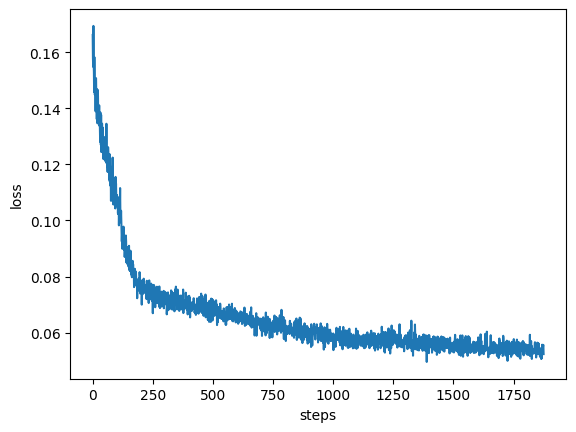

In [224]:
# training logs
plt.plot(losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [225]:
# analysis
num_samples = 512

viz_dataloader = DataLoader(test_dataset, batch_size=num_samples, shuffle=True)

x, y = next(iter(viz_dataloader))
x = x.reshape(x.shape[0], -1)
z = ae.encode(x)
z = z.detach().numpy()

tsne = TSNE()
z = tsne.fit_transform(z)

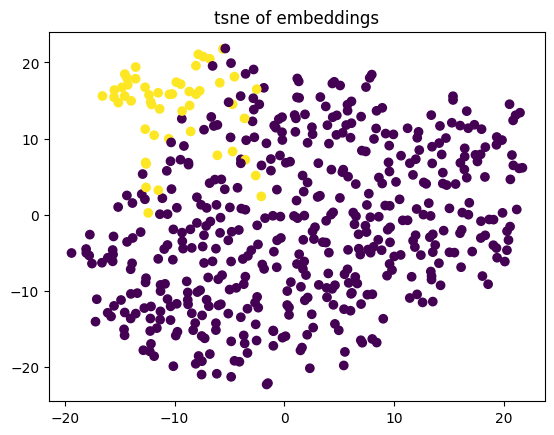

In [235]:
viz_label = 0
plt.scatter(z[:, 0], z[:, 1], c=(y==viz_label))
plt.title('tsne of embeddings')
plt.show()

citations:
* https://github.com/AntixK/PyTorch-VAE
* 182 hw7

